In [7]:
import yaml
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# from functions.process_data import *
# from main import dict2namespace
# from runners.image_editing import *
# from models.diffusion import Model
# from colab_utils.utils import *
import torchgeometry as tgm
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
import torch_dct as dct
import torch
import torchvision
from torchvision.utils import make_grid, save_image
from torchvision import transforms
import copy
from torchvision.utils import make_grid, save_image
os.chdir("/home/bastienvandelft/Projects/")
from ddpm.datasets.corruptions import glass_blur
warnings.filterwarnings("ignore")


In [15]:
from ddpm.datasets import get_dataset
from ddpm.diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler, HeatDiffusionTrainer, HeatDiffusionSampler
from ddpm.model import UNet
from ddpm.score.both import get_inception_and_fid_score

In [44]:
# FLAGS = flags.FLAGS
# flags.DEFINE_bool('train', True, help='train from scratch')
# flags.DEFINE_bool('eval', False, help='load ckpt.pt and evaluate FID and IS')
# # Dataset
# flags.DEFINE_string('datapath', '/mnt/scitas/bastien/', help='dataset path if downloaded')
# flags.DEFINE_string('dataset', 'CELEBA', help='dataset name')
# flags.DEFINE_string('corruption', None, help='corruption type base on Imagenet-C')
# flags.DEFINE_integer('corruption_severity', None, help='corruption severity level 1-5')
# flags.DEFINE_bool('random_flip', False, help='Whether to use random flip in training')
# # UNet
# flags.DEFINE_integer('ch', 128, help='base channel of UNet')
# flags.DEFINE_multi_integer('ch_mult', [1, 2,2, 4, 8], help='channel multiplier')
# flags.DEFINE_multi_integer('attn', [2], help='add attention to these levels')
# flags.DEFINE_integer('num_res_blocks', 3, help='# resblock in each level')
# flags.DEFINE_float('dropout', 0.1, help='dropout rate of resblock')
# # Gaussian Diffusion
# flags.DEFINE_float('beta_1', 1e-4, help='start beta value')
# flags.DEFINE_float('beta_T', 0.02, help='end beta value')
# flags.DEFINE_integer('T', 1000, help='total diffusion steps')
# flags.DEFINE_enum('mean_type', 'epsilon', ['xprev', 'xstart', 'epsilon'], help='predict variable')
# flags.DEFINE_enum('var_type', 'fixedlarge', ['fixedlarge', 'fixedsmall'], help='variance type')
# # Training
# flags.DEFINE_float('lr', 2e-4, help='target learning rate')
# flags.DEFINE_float('grad_clip', 1., help="gradient norm clipping")
# flags.DEFINE_integer('total_steps', 800000, help='total training steps')
# flags.DEFINE_integer('img_size', 64, help='image size')
# flags.DEFINE_integer('warmup', 5000, help='learning rate warmup')
# flags.DEFINE_integer('batch_size', 32, help='batch size')
# flags.DEFINE_integer('num_workers', 4, help='workers of Dataloader')
# flags.DEFINE_float('ema_decay', 0.9999, help="ema decay rate")
# flags.DEFINE_bool('parallel', True, help='multi gpu training')
# # Logging & Sampling
# flags.DEFINE_string('logdir', './logs/Celeba', help='log directory')
# flags.DEFINE_string('wandb_entity', 'bastienvd', help='wandb id to use')
# flags.DEFINE_integer('sample_size', 64, "sampling size of images")
# flags.DEFINE_integer('sample_step', 2000, help='frequency of sampling')
# flags.DEFINE_string('ml_exp_name', 'CelebA', help = 'name of the experience on wandb')
# # Evaluation
# flags.DEFINE_integer('save_step', 20000, help='frequency of saving checkpoints, 0 to disable during training')
# flags.DEFINE_integer('eval_step', 0, help='frequency of evaluating model, 0 to disable during training')
# flags.DEFINE_integer('num_images', 50000, help='the number of generated images for evaluation')
# flags.DEFINE_bool('fid_use_torch', False, help='calculate IS and FID on gpu')
# flags.DEFINE_string('fid_cache', './stats/cifar10.train.npz', help='FID cache')

device = torch.device('cuda:0')


In [17]:
class Args:
    datapath = '/mnt/scitas/bastien/'
    dataset = 'CELEBA'
    corruption = None
    corruption_severity = 5
    random_flip = False
    ch = 128
    ch_mult = [1, 2, 2, 4, 8]
    attn = [2]
    num_res_blocks = 3
    dropout = 0.1
    beta_1 = 1e-4
    beta_T = 0.02
    T = 1000
    mean_type = 'epsilon'
    var_type = 'fixedlarge'
    lr = 2e-4
    grad_clip = 1.
    img_size = 64
    batch_size = 8
    num_workers = 4
    parallel = True
    sample_size = 64
    
    
    

args=Args()


# flags.DEFINE_bool('train', True, help='train from scratch')
# flags.DEFINE_bool('eval', False, help='load ckpt.pt and evaluate FID and IS')


In [19]:
def infiniteloop(dataloader):
    while True:
        for x, y, z in iter(dataloader):
            yield x
            
dataset, test_dataset = get_dataset(args, None)
dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=True,
        num_workers=args.num_workers, drop_last=True)
datalooper = infiniteloop(dataloader)

dataset_name CELEBA


In [51]:
device = torch.device('cuda:0')
# model = UNet(
#         T=args.T, ch=args.ch, ch_mult=args.ch_mult, attn=args.attn,
#         num_res_blocks=args.num_res_blocks, dropout=args.dropout)
ema_model = UNet(
        T=args.T, ch=args.ch, ch_mult=args.ch_mult, attn=args.attn,
        num_res_blocks=args.num_res_blocks, dropout=args.dropout)

ckpt = torch.load(os.path.join('/home/bastienvandelft/Projects/ddpm/logs/Celeba', 'ckpt_350000.pt'))
# model.load_state_dict(ckpt['net_model'])
ema_model.load_state_dict(ckpt['ema_model'])
sampler = GaussianDiffusionSampler(
        ema_model, args.beta_1, args.beta_T, args.T, args.img_size,
        ).to(device)
ema_sampler = HeatDiffusionSampler(
        ema_model, args.beta_1, args.beta_T, args.T, args.img_size).to(device)
# trainer = GaussianDiffusionTrainer(
#         model, args.beta_1, args.beta_T, args.T).to(device)
del ckpt

In [52]:
with torch.no_grad():
    classic_sample = sampler(torch.randn_like(x_0.to(device)))

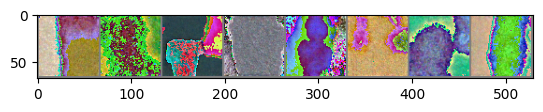

In [53]:
data = (make_grid(classic_sample.cpu()) + 1) / 2
data = data.permute(1,2,0)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [31]:
# x_0 = next(datalooper).to(device)
x_T = torch.randn_like(x_0)


In [21]:
time_step = 999
# t = x_T.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
t = torch.tensor([time_step] * x_T.shape[0], device=device)


torch.Size([68, 530, 3])


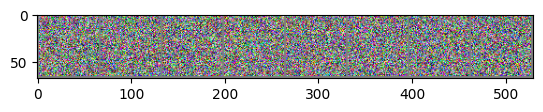

In [10]:
dic = ema_sampler.ddim_sample(x_T, t,eta = 0.5)
sample = dic['sample']
data = (make_grid(sample.cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

torch.Size([68, 530, 3])


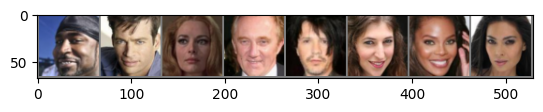

In [32]:
data = (make_grid(x_0.cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [33]:
with torch.no_grad():
    reverse_samples = ema_sampler.ddim_reverse_sample_loop_progressive(x_0, eta = 0.)
    ema_sampler.num_timesteps = ema_sampler.T
liste_of_reversed_tensor = []
for dic in reverse_samples:
    liste_of_reversed_tensor.append(dic['sample'])

AttributeError: 'HeatDiffusionSampler' object has no attribute 'p_mean_variance'

In [ ]:
# Reversed Encoding
data = (make_grid(liste_of_reversed_tensor[-1].cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [ ]:
with torch.no_grad():
    ddim_decode_sample = ema_sampler.ddim_sample_loop_progressive(x_0.shape, noise=liste_of_reversed_tensor[-1], eta=0.)
liste_of_generated_tensor = []
for dic in ddim_decode_sample:
    liste_of_generated_tensor.append(dic['sample'])

In [ ]:
# Decoding
data = (make_grid(liste_of_generated_tensor[-1].cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [36]:
with torch.no_grad():
    samples = ema_sampler.ddim_sample_loop_progressive(x_0.shape, eta = 0.
                                                      )
liste_of_tensor = []
liste_of_x0 = []
for dic in samples:
    liste_of_x0.append(dic['pred_xstart'])
    liste_of_tensor.append(dic['sample'])

torch.Size([68, 530, 3])


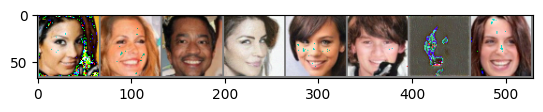

In [37]:
# Generating
data = (make_grid(liste_of_tensor[-1].cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

torch.Size([68, 530, 3])


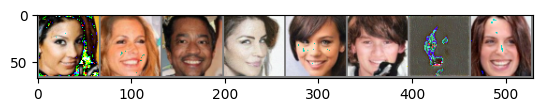

In [38]:
# Generating
data = (make_grid(liste_of_x0[-1].cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [39]:
with torch.no_grad():
    samples = ema_sampler.ddim_sample_loop_progressive(x_0.shape, eta = 0.1)
liste_of_fast_tensor = []
liste_of_fast_x0 = []
for dic in samples:
    liste_of_fast_x0.append(dic['pred_xstart'])
    liste_of_fast_tensor.append(dic['sample'])

torch.Size([68, 530, 3])


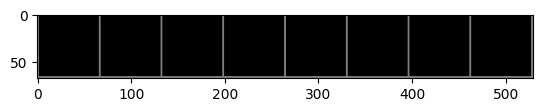

In [42]:
# Generating
data = (make_grid(liste_of_fast_x0[-1].cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [48]:
with torch.no_grad():
    classic_sample = ema_sampler(torch.randn_like(x_0.to(device)))

Check difference bis u_x versions : tensor(-5.1626e-07, device='cuda:0')
Check difference bis u_x versions : tensor(7.7941e-06, device='cuda:0')
Check difference bis u_x versions : tensor(5.6647e-05, device='cuda:0')
Check difference bis u_x versions : tensor(1.8388e-05, device='cuda:0')
Check difference bis u_x versions : tensor(-2.1315e-05, device='cuda:0')
Check difference bis u_x versions : tensor(-5.9873e-05, device='cuda:0')
Check difference bis u_x versions : tensor(3.6840e-05, device='cuda:0')
Check difference bis u_x versions : tensor(4.1355e-05, device='cuda:0')
Check difference bis u_x versions : tensor(-4.0982e-05, device='cuda:0')
Check difference bis u_x versions : tensor(-6.9670e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-6.8700e-06, device='cuda:0')
Check difference bis u_x versions : tensor(1.5630e-05, device='cuda:0')
Check difference bis u_x versions : tensor(3.4724e-06, device='cuda:0')
Check difference bis u_x versions : tensor(8.7448e-06, dev

Check difference bis u_x versions : tensor(-2.7999e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-5.2176e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-1.0579e-06, device='cuda:0')
Check difference bis u_x versions : tensor(1.7480e-06, device='cuda:0')
Check difference bis u_x versions : tensor(9.3636e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.0731e-06, device='cuda:0')
Check difference bis u_x versions : tensor(1.5229e-06, device='cuda:0')
Check difference bis u_x versions : tensor(6.5766e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.0283e-06, device='cuda:0')
Check difference bis u_x versions : tensor(8.5699e-07, device='cuda:0')
Check difference bis u_x versions : tensor(5.7042e-06, device='cuda:0')
Check difference bis u_x versions : tensor(2.2332e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-3.4743e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-1.4794e-06, dev

Check difference bis u_x versions : tensor(5.1852e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-1.8572e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-2.0596e-06, device='cuda:0')
Check difference bis u_x versions : tensor(2.1359e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.9171e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-1.2353e-06, device='cuda:0')
Check difference bis u_x versions : tensor(8.9869e-07, device='cuda:0')
Check difference bis u_x versions : tensor(9.5395e-07, device='cuda:0')
Check difference bis u_x versions : tensor(2.3299e-08, device='cuda:0')
Check difference bis u_x versions : tensor(8.6973e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.2790e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-1.5505e-07, device='cuda:0')
Check difference bis u_x versions : tensor(4.0694e-07, device='cuda:0')
Check difference bis u_x versions : tensor(4.0570e-07, devic

Check difference bis u_x versions : tensor(-4.7668e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-6.9274e-07, device='cuda:0')
Check difference bis u_x versions : tensor(3.8728e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.0739e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-7.1060e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-1.4173e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-1.2512e-07, device='cuda:0')
Check difference bis u_x versions : tensor(4.4018e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.2161e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.5221e-07, device='cuda:0')
Check difference bis u_x versions : tensor(7.5364e-07, device='cuda:0')
Check difference bis u_x versions : tensor(3.7244e-08, device='cuda:0')
Check difference bis u_x versions : tensor(1.2566e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-8.6345e-07, 

Check difference bis u_x versions : tensor(8.2486e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-8.7288e-07, device='cuda:0')
Check difference bis u_x versions : tensor(5.3311e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-3.5743e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-3.1206e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-9.5130e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-3.7321e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-1.4273e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-4.4152e-07, device='cuda:0')
Check difference bis u_x versions : tensor(9.2277e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-9.3085e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-9.7569e-08, device='cuda:0')
Check difference bis u_x versions : tensor(2.2920e-07, device='cuda:0')
Check difference bis u_x versions : tensor(6.3263e-07, 

Check difference bis u_x versions : tensor(-1.6338e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-4.4004e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-1.1941e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-1.1125e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-1.9647e-08, device='cuda:0')
Check difference bis u_x versions : tensor(2.1669e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-9.8098e-08, device='cuda:0')
Check difference bis u_x versions : tensor(5.5559e-08, device='cuda:0')
Check difference bis u_x versions : tensor(5.8527e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.2339e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-2.9835e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-7.5024e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.1860e-07, device='cuda:0')
Check difference bis u_x versions : tensor(2.3702e-07, 

Check difference bis u_x versions : tensor(1.7433e-07, device='cuda:0')
Check difference bis u_x versions : tensor(2.9223e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-5.6141e-08, device='cuda:0')
Check difference bis u_x versions : tensor(4.6497e-07, device='cuda:0')
Check difference bis u_x versions : tensor(3.6362e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.3532e-07, device='cuda:0')
Check difference bis u_x versions : tensor(2.1970e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-4.1529e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-2.6947e-07, device='cuda:0')
Check difference bis u_x versions : tensor(2.4894e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-2.8414e-07, device='cuda:0')
Check difference bis u_x versions : tensor(5.6789e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.0671e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.1016e-08, devi

Check difference bis u_x versions : tensor(-4.6281e-08, device='cuda:0')
Check difference bis u_x versions : tensor(1.7655e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-6.9087e-09, device='cuda:0')
Check difference bis u_x versions : tensor(3.9075e-10, device='cuda:0')
Check difference bis u_x versions : tensor(6.5707e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-2.6868e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-2.3892e-08, device='cuda:0')
Check difference bis u_x versions : tensor(4.9746e-09, device='cuda:0')
Check difference bis u_x versions : tensor(-1.3973e-09, device='cuda:0')
Check difference bis u_x versions : tensor(1.0425e-09, device='cuda:0')
Check difference bis u_x versions : tensor(-3.5198e-09, device='cuda:0')
Check difference bis u_x versions : tensor(1.5744e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-1.1824e-08, device='cuda:0')
Check difference bis u_x versions : tensor(9.0413e-09, de

Check difference bis u_x versions : tensor(-5.2533e-12, device='cuda:0')
Check difference bis u_x versions : tensor(-1.9833e-10, device='cuda:0')
Check difference bis u_x versions : tensor(-1.3069e-10, device='cuda:0')
Check difference bis u_x versions : tensor(1.5858e-10, device='cuda:0')
Check difference bis u_x versions : tensor(6.7513e-10, device='cuda:0')
Check difference bis u_x versions : tensor(-3.8561e-10, device='cuda:0')
Check difference bis u_x versions : tensor(1.1208e-11, device='cuda:0')
Check difference bis u_x versions : tensor(1.7728e-12, device='cuda:0')
Check difference bis u_x versions : tensor(-3.3381e-10, device='cuda:0')
Check difference bis u_x versions : tensor(2.3802e-10, device='cuda:0')
Check difference bis u_x versions : tensor(2.4145e-10, device='cuda:0')
Check difference bis u_x versions : tensor(5.9760e-10, device='cuda:0')
Check difference bis u_x versions : tensor(1.7184e-10, device='cuda:0')
Check difference bis u_x versions : tensor(-9.1016e-11, dev

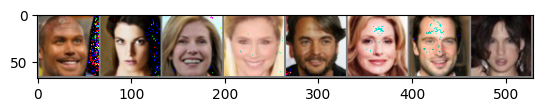

In [49]:
data = (make_grid(classic_sample.cpu()) + 1) / 2
data = data.permute(1,2,0)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

torch.Size([68, 530, 3])


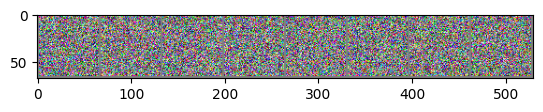

In [54]:
t = t - 1
with torch.no_grad():
    dic = ema_sampler.ddim_sample(sample, t)
sample = dic['sample']
data = (make_grid(sample.cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [22]:
with torch.no_grad():
    samples = ema_sampler.ddim_sample_loop_progressive(x_0.shape, eta = 0.
                                                      )
liste_of_tensor = []
liste_of_x0 = []
for dic in samples:
    liste_of_x0.append(dic['pred_xstart'])
    liste_of_ftensor.append(dic['sample'])

In [9]:
with torch.no_grad():
    classic_sample = ema_sampler(torch.randn_like(x_0))

Check difference bis u_x versions : tensor(-5.7695e-05, device='cuda:0')
Check difference bis u_x versions : tensor(3.7926e-05, device='cuda:0')
Check difference bis u_x versions : tensor(5.2987e-05, device='cuda:0')
Check difference bis u_x versions : tensor(3.0404e-05, device='cuda:0')
Check difference bis u_x versions : tensor(4.3296e-05, device='cuda:0')
Check difference bis u_x versions : tensor(4.9654e-05, device='cuda:0')
Check difference bis u_x versions : tensor(-8.1528e-05, device='cuda:0')
Check difference bis u_x versions : tensor(2.9216e-05, device='cuda:0')
Check difference bis u_x versions : tensor(9.7141e-06, device='cuda:0')
Check difference bis u_x versions : tensor(2.4344e-05, device='cuda:0')
Check difference bis u_x versions : tensor(-4.7592e-06, device='cuda:0')
Check difference bis u_x versions : tensor(2.1525e-05, device='cuda:0')
Check difference bis u_x versions : tensor(2.9897e-05, device='cuda:0')
Check difference bis u_x versions : tensor(8.3100e-06, device

Check difference bis u_x versions : tensor(1.1142e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-1.8635e-06, device='cuda:0')
Check difference bis u_x versions : tensor(8.3735e-07, device='cuda:0')
Check difference bis u_x versions : tensor(4.6916e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-1.9611e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-1.3666e-06, device='cuda:0')
Check difference bis u_x versions : tensor(5.7294e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-4.2455e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-7.3137e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-8.5547e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-1.3055e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-3.5741e-06, device='cuda:0')
Check difference bis u_x versions : tensor(1.2181e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-5.0575e-07, 

Check difference bis u_x versions : tensor(-2.0328e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-2.8128e-06, device='cuda:0')
Check difference bis u_x versions : tensor(4.4697e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-6.6073e-07, device='cuda:0')
Check difference bis u_x versions : tensor(5.4248e-07, device='cuda:0')
Check difference bis u_x versions : tensor(6.9740e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.3884e-06, device='cuda:0')
Check difference bis u_x versions : tensor(1.6878e-07, device='cuda:0')
Check difference bis u_x versions : tensor(8.8097e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.6809e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-1.3935e-06, device='cuda:0')
Check difference bis u_x versions : tensor(3.4230e-07, device='cuda:0')
Check difference bis u_x versions : tensor(8.2550e-07, device='cuda:0')
Check difference bis u_x versions : tensor(9.9278e-07, devi

Check difference bis u_x versions : tensor(-1.4560e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-8.8704e-08, device='cuda:0')
Check difference bis u_x versions : tensor(1.0720e-06, device='cuda:0')
Check difference bis u_x versions : tensor(6.2493e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-1.0442e-06, device='cuda:0')
Check difference bis u_x versions : tensor(4.6186e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-1.2467e-06, device='cuda:0')
Check difference bis u_x versions : tensor(7.7526e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-6.9278e-07, device='cuda:0')
Check difference bis u_x versions : tensor(2.0976e-06, device='cuda:0')
Check difference bis u_x versions : tensor(7.0550e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-1.1707e-06, device='cuda:0')
Check difference bis u_x versions : tensor(-9.4914e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-1.1714e-07, d

Check difference bis u_x versions : tensor(-4.5981e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-3.8200e-07, device='cuda:0')
Check difference bis u_x versions : tensor(2.7617e-07, device='cuda:0')
Check difference bis u_x versions : tensor(3.4190e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-5.3118e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-6.8892e-07, device='cuda:0')
Check difference bis u_x versions : tensor(7.1038e-07, device='cuda:0')
Check difference bis u_x versions : tensor(7.3954e-07, device='cuda:0')
Check difference bis u_x versions : tensor(3.3784e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.9170e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.3118e-07, device='cuda:0')
Check difference bis u_x versions : tensor(7.6777e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-9.2703e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.0474e-06, devi

Check difference bis u_x versions : tensor(-1.8105e-07, device='cuda:0')
Check difference bis u_x versions : tensor(6.4704e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.2552e-07, device='cuda:0')
Check difference bis u_x versions : tensor(4.3808e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-5.6010e-07, device='cuda:0')
Check difference bis u_x versions : tensor(7.1669e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-2.4377e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-3.6261e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-3.1458e-08, device='cuda:0')
Check difference bis u_x versions : tensor(2.2218e-07, device='cuda:0')
Check difference bis u_x versions : tensor(6.3172e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-1.8634e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.9830e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-5.5402e-07, 

Check difference bis u_x versions : tensor(-2.4931e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-1.7340e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-8.8106e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-4.5292e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.5493e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-4.5120e-07, device='cuda:0')
Check difference bis u_x versions : tensor(6.0285e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-2.9090e-07, device='cuda:0')
Check difference bis u_x versions : tensor(4.3643e-07, device='cuda:0')
Check difference bis u_x versions : tensor(3.2302e-07, device='cuda:0')
Check difference bis u_x versions : tensor(1.5119e-07, device='cuda:0')
Check difference bis u_x versions : tensor(-3.7325e-07, device='cuda:0')
Check difference bis u_x versions : tensor(3.7180e-07, device='cuda:0')
Check difference bis u_x versions : tensor(3.1227e-07, d

Check difference bis u_x versions : tensor(-6.9429e-09, device='cuda:0')
Check difference bis u_x versions : tensor(3.0785e-08, device='cuda:0')
Check difference bis u_x versions : tensor(1.8456e-08, device='cuda:0')
Check difference bis u_x versions : tensor(1.1110e-08, device='cuda:0')
Check difference bis u_x versions : tensor(-7.2542e-09, device='cuda:0')
Check difference bis u_x versions : tensor(1.9828e-08, device='cuda:0')
Check difference bis u_x versions : tensor(1.2654e-08, device='cuda:0')
Check difference bis u_x versions : tensor(8.0989e-09, device='cuda:0')
Check difference bis u_x versions : tensor(2.5325e-09, device='cuda:0')
Check difference bis u_x versions : tensor(7.9006e-09, device='cuda:0')
Check difference bis u_x versions : tensor(5.4318e-09, device='cuda:0')
Check difference bis u_x versions : tensor(9.0496e-09, device='cuda:0')
Check difference bis u_x versions : tensor(-6.5455e-09, device='cuda:0')
Check difference bis u_x versions : tensor(-7.6205e-09, devic

Check difference bis u_x versions : tensor(1.5368e-10, device='cuda:0')
Check difference bis u_x versions : tensor(-7.0990e-11, device='cuda:0')
Check difference bis u_x versions : tensor(-9.7330e-11, device='cuda:0')
Check difference bis u_x versions : tensor(2.2990e-10, device='cuda:0')
Check difference bis u_x versions : tensor(1.7182e-11, device='cuda:0')
Check difference bis u_x versions : tensor(-6.1862e-10, device='cuda:0')
Check difference bis u_x versions : tensor(-5.6388e-10, device='cuda:0')
Check difference bis u_x versions : tensor(2.8951e-11, device='cuda:0')
Check difference bis u_x versions : tensor(7.3724e-11, device='cuda:0')
Check difference bis u_x versions : tensor(1.2795e-10, device='cuda:0')
Check difference bis u_x versions : tensor(9.2629e-11, device='cuda:0')
Check difference bis u_x versions : tensor(2.7228e-12, device='cuda:0')
Check difference bis u_x versions : tensor(1.0055e-10, device='cuda:0')
Check difference bis u_x versions : tensor(4.2965e-11, devic

torch.Size([68, 530, 3])


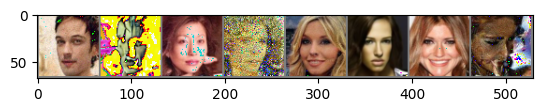

In [27]:
data = (make_grid(liste_of_tensor[999].cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

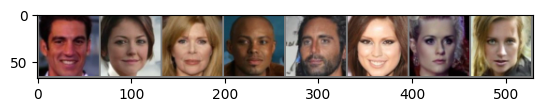

In [12]:
data = (make_grid(sample.cpu()) + 1) / 2
data = data.permute(1,2,0)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

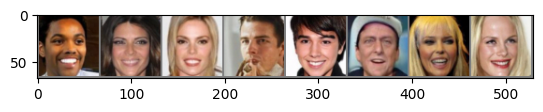

In [23]:
data = (make_grid(pred.cpu()) + 1) / 2
data = data.permute(1,2,0)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [10]:
# device_bis = torch.device('cuda:2')
# noisy_model = UNet(
#         T=args.T, ch=args.ch, ch_mult=args.ch_mult, attn=args.attn,
#         num_res_blocks=args.num_res_blocks, dropout=args.dropout)
noisy_ema_model = UNet(
        T=args.T, ch=args.ch, ch_mult=args.ch_mult, attn=args.attn,
        num_res_blocks=args.num_res_blocks, dropout=args.dropout)
noisy_ckpt = torch.load(os.path.join('/mnt/scitas/bastien/logs/Celeba_Gaussian_Snow/', 'ckpt_450000.pt'))

# noisy_model.load_state_dict(ckpt['net_model'])
noisy_ema_model.load_state_dict(noisy_ckpt['ema_model'])
noisy_ema_sampler = GaussianDiffusionSampler(
        noisy_ema_model, args.beta_1, args.beta_T, args.T, args.img_size).to(device)
del noisy_ckpt

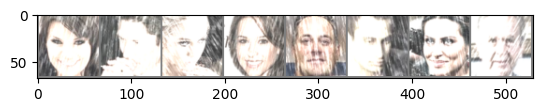

In [7]:
data = (make_grid(x_0.cpu()) + 1) / 2
data = data.permute(1,2,0)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [11]:
reverse_samples = noisy_ema_sampler.ddim_reverse_sample_loop_progressive(x_0)
noisy_ema_sampler.num_timesteps = noisy_ema_sampler.T

In [12]:
reverse_samples_from_target = ema_sampler.ddim_reverse_sample_loop_progressive(x_0)
ema_sampler.num_timesteps = ema_sampler.T

In [13]:
liste_of_tensor = []
for dic in reverse_samples:
    liste_of_tensor.append(dic['sample'])

In [14]:
liste_of_tensor_from_target = []
for dic in reverse_samples_from_target:
    liste_of_tensor_from_target.append(dic['sample'])

torch.Size([68, 530, 3])


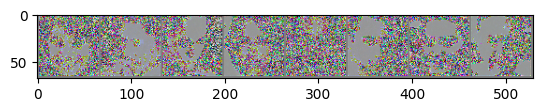

In [16]:
data = (make_grid(liste_of_tensor[600].cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [17]:
ddim_sample = ema_sampler.ddim_sample_loop_progressive(x_0.shape, noise=liste_of_tensor[-1])

In [18]:
liste_of_generated_tensor = []
for dic in ddim_sample:
    liste_of_generated_tensor.append(dic['sample'])

torch.Size([68, 530, 3])


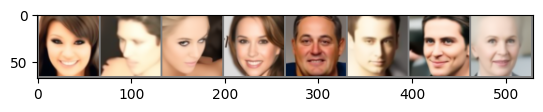

In [19]:
data = (make_grid(liste_of_generated_tensor[-1].cpu()) + 1) / 2
data = data.permute(1,2,0)
print(data.shape)
data_np = np.array((data*255), dtype=np.uint8)
plt.imshow(data_np)

In [11]:
from scipy.ndimage import zoom as scizoom
from PIL import Image as PILImage
from kornia.color.gray import rgb_to_grayscale
from kornia.color.rgb import linear_rgb_to_rgb, rgb_to_linear_rgb
from kornia.color.xyz import rgb_to_xyz, xyz_to_rgb
import cv2
import math

import torch.nn as nn



def rgb2hsv(image_old: torch.Tensor, eps: float = 1e-8, rescale=True) -> torch.Tensor:
    r"""Convert an image from RGB to HSV.

    .. image:: _static/img/rgb_to_hsv.png

    The image data is assumed to be in the range of (0, 1).

    Args:
        image: RGB Image to be converted to HSV with shape of :math:`(*, 3, H, W)`.
        eps: scalar to enforce numarical stability.

    Returns:
        HSV version of the image with shape of :math:`(*, 3, H, W)`.
        The H channel values are in the range 0..2pi. S and V are in the range 0..1.

    .. note::
       See a working example `here <https://kornia-tutorials.readthedocs.io/en/latest/
       color_conversions.html>`__.

    Example:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = rgb_to_hsv(input)  # 2x3x4x5
    """
    if rescale: 
        image = (image_old + 1) * 0.5
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    max_rgb, argmax_rgb = image.max(-3)
    min_rgb, argmin_rgb = image.min(-3)
    deltac = max_rgb - min_rgb

    v = max_rgb
    s = deltac / (max_rgb + eps)

    deltac = torch.where(deltac == 0, torch.ones_like(deltac), deltac)
    rc, gc, bc = torch.unbind((max_rgb.unsqueeze(-3) - image), dim=-3)

    h1 = (bc - gc)
    h2 = (rc - bc) + 2.0 * deltac
    h3 = (gc - rc) + 4.0 * deltac

    h = torch.stack((h1, h2, h3), dim=-3) / deltac.unsqueeze(-3)
    h = torch.gather(h, dim=-3, index=argmax_rgb.unsqueeze(-3)).squeeze(-3)
    h = (h / 6.0) % 1.0
    h = 2. * math.pi * h  # we return 0/2pi output

    return torch.stack((h, s, v), dim=-3)



def hsv2rgb(image: torch.Tensor, rescale=True) -> torch.Tensor:
    r"""Convert an image from HSV to RGB.

    The H channel values are assumed to be in the range 0..2pi. S and V are in the range 0..1.

    Args:
        image: HSV Image to be converted to HSV with shape of :math:`(*, 3, H, W)`.

    Returns:
        RGB version of the image with shape of :math:`(*, 3, H, W)`.

    Example:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = hsv_to_rgb(input)  # 2x3x4x5
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    h: torch.Tensor = image[..., 0, :, :] / (2 * math.pi)
    s: torch.Tensor = image[..., 1, :, :]
    v: torch.Tensor = image[..., 2, :, :]

    hi: torch.Tensor = torch.floor(h * 6) % 6
    f: torch.Tensor = ((h * 6) % 6) - hi
    one: torch.Tensor = torch.tensor(1.0, device=image.device, dtype=image.dtype)
    p: torch.Tensor = v * (one - s)
    q: torch.Tensor = v * (one - f * s)
    t: torch.Tensor = v * (one - (one - f) * s)

    hi = hi.long()
    indices: torch.Tensor = torch.stack([hi, hi + 6, hi + 12], dim=-3)
    out = torch.stack((v, q, p, p, t, v, t, v, v, q, p, p, p, p, t, v, v, q), dim=-3)
    out = torch.gather(out, -3, indices)
    
    if rescale:
        out = 2.0 * out - 1

    return out


"""
The RGB to Lab color transformations were translated from scikit image's rgb2lab and lab2rgb

https://github.com/scikit-image/scikit-image/blob/a48bf6774718c64dade4548153ae16065b595ca9/skimage/color/colorconv.py

"""

def rgb2lab(image_old: torch.Tensor) -> torch.Tensor:
    r"""Convert a RGB image to Lab.

    .. image:: _static/img/rgb_to_lab.png

    The image data is assumed to be in the range of :math:`[0, 1]`. Lab
    color is computed using the D65 illuminant and Observer 2.

    Args:
        image: RGB Image to be converted to Lab with shape :math:`(*, 3, H, W)`.

    Returns:
        Lab version of the image with shape :math:`(*, 3, H, W)`.
        The L channel values are in the range 0..100. a and b are in the range -127..127.

    Example:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = rgb_to_lab(input)  # 2x3x4x5
    """
    image = (image_old + 1) * 0.5
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    # Convert from sRGB to Linear RGB
    lin_rgb = rgb_to_linear_rgb(image)

    xyz_im: torch.Tensor = rgb_to_xyz(lin_rgb)

    # normalize for D65 white point
    xyz_ref_white = torch.tensor([0.95047, 1.0, 1.08883], device=xyz_im.device, dtype=xyz_im.dtype)[..., :, None, None]
    xyz_normalized = torch.div(xyz_im, xyz_ref_white)

    threshold = 0.008856
    power = torch.pow(xyz_normalized.clamp(min=threshold), 1 / 3.0)
    scale = 7.787 * xyz_normalized + 4.0 / 29.0
    xyz_int = torch.where(xyz_normalized > threshold, power, scale)

    x: torch.Tensor = xyz_int[..., 0, :, :]
    y: torch.Tensor = xyz_int[..., 1, :, :]
    z: torch.Tensor = xyz_int[..., 2, :, :]

    L: torch.Tensor = (116.0 * y) - 16.0
    a: torch.Tensor = 500.0 * (x - y)
    _b: torch.Tensor = 200.0 * (y - z)

    out: torch.Tensor = torch.stack([L, a, _b], dim=-3)

    return out


def lab2rgb(image: torch.Tensor, clip: bool = True) -> torch.Tensor:
    r"""Convert a Lab image to RGB.

    Args:
        image: Lab image to be converted to RGB with shape :math:`(*, 3, H, W)`.
        clip: Whether to apply clipping to insure output RGB values in range :math:`[0, 1]`.

    Returns:
        Lab version of the image with shape :math:`(*, 3, H, W)`.

    Example:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = lab_to_rgb(input)  # 2x3x4x5
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(image)}")

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError(f"Input size must have a shape of (*, 3, H, W). Got {image.shape}")

    L: torch.Tensor = image[..., 0, :, :]
    a: torch.Tensor = image[..., 1, :, :]
    _b: torch.Tensor = image[..., 2, :, :]

    fy = (L + 16.0) / 116.0
    fx = (a / 500.0) + fy
    fz = fy - (_b / 200.0)

    # if color data out of range: Z < 0
    fz = fz.clamp(min=0.0)

    fxyz = torch.stack([fx, fy, fz], dim=-3)

    # Convert from Lab to XYZ
    power = torch.pow(fxyz, 3.0)
    scale = (fxyz - 4.0 / 29.0) / 7.787
    xyz = torch.where(fxyz > 0.2068966, power, scale)

    # For D65 white point
    xyz_ref_white = torch.tensor([0.95047, 1.0, 1.08883], device=xyz.device, dtype=xyz.dtype)[..., :, None, None]
    xyz_im = xyz * xyz_ref_white

    rgbs_im: torch.Tensor = xyz_to_rgb(xyz_im)

    # https://github.com/richzhang/colorization-pytorch/blob/66a1cb2e5258f7c8f374f582acc8b1ef99c13c27/util/util.py#L107
    #     rgbs_im = torch.where(rgbs_im < 0, torch.zeros_like(rgbs_im), rgbs_im)

    # Convert from RGB Linear to sRGB
    rgb_im = linear_rgb_to_rgb(rgbs_im)

    # Clip to 0,1 https://www.w3.org/Graphics/Color/srgb
    if clip:
        rgb_im = torch.clamp(rgb_im, min=0.0, max=1.0)
    
    rgb_im = 2.0 * rgb_im - 1

    return rgb_im


class RgbToLab(nn.Module):
    r"""Convert an image from RGB to Lab.

    The image data is assumed to be in the range of :math:`[0, 1]`. Lab
    color is computed using the D65 illuminant and Observer 2.

    Returns:
        Lab version of the image.

    Shape:
        - image: :math:`(*, 3, H, W)`
        - output: :math:`(*, 3, H, W)`

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> lab = RgbToLab()
        >>> output = lab(input)  # 2x3x4x5

    Reference:
        [1] https://docs.opencv.org/4.0.1/de/d25/imgproc_color_conversions.html

        [2] https://www.easyrgb.com/en/math.php

        [3] https://github.com/torch/image/blob/dc061b98fb7e946e00034a5fc73e883a299edc7f/generic/image.c#L1467
    """

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        return rgb_to_lab(image)




class LabToRgb(nn.Module):
    r"""Convert an image from Lab to RGB.

    Returns:
        RGB version of the image. Range may not be in :math:`[0, 1]`.

    Shape:
        - image: :math:`(*, 3, H, W)`
        - output: :math:`(*, 3, H, W)`

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> rgb = LabToRgb()
        >>> output = rgb(input)  # 2x3x4x5

    References:
        [1] https://docs.opencv.org/4.0.1/de/d25/imgproc_color_conversions.html

        [2] https://www.easyrgb.com/en/math.php

        [3] https://github.com/torch/image/blob/dc061b98fb7e946e00034a5fc73e883a299edc7f/generic/image.c#L1518
    """

    def forward(self, image: torch.Tensor, clip: bool = True) -> torch.Tensor:
        return lab_to_rgb(image, clip)



def clipped_zoom(img, zoom_factor):
    h = img.shape[0]
    # ceil crop height(= crop width)
    ch = int(np.ceil(h / zoom_factor))

    top = (h - ch) // 2
    img = scizoom(img[top:top + ch, top:top + ch], (zoom_factor, zoom_factor, 1), order=1)
    # trim off any extra pixels
    trim_top = (img.shape[0] - h) // 2

    return img[trim_top:trim_top + h, trim_top:trim_top + h]

In [12]:
# def get_config(file):
#     with open(os.path.join('', 'configs', file), 'r') as f:
#         config = yaml.safe_load(f)
#     new_config = dict2namespace(config)
#     return new_config


# def load_model(dataset, category, file):
#     url = get_checkpoint(dataset, category)
#     config = get_config(file)
#     model = Model(config)
#     ckpt = torch.hub.load_state_dict_from_url(url, map_location=device)
#     model.load_state_dict(ckpt)
#     model.to(device)
#     model = torch.nn.DataParallel(model)
#     model.eval()
#     print("Model loaded")

#     betas = get_beta_schedule(
#         beta_start=config.diffusion.beta_start,
#         beta_end=config.diffusion.beta_end,
#         num_diffusion_timesteps=config.diffusion.num_diffusion_timesteps
#     )
#     betas = torch.from_numpy(betas).float()
#     num_timesteps = betas.shape[0]

#     alphas = 1.0 - betas
#     alphas_cumprod = np.cumprod(alphas, axis=0)
#     alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
#     posterior_variance = betas * \
#         (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
#     logvar = np.log(np.maximum(posterior_variance, 1e-20))

#     return model, betas, num_timesteps, logvar

In [13]:
# def SDEditing_bis(betas, logvar, model, name, sample_step, total_noise_levels, n=4):
#     print("Start sampling")

#     with torch.no_grad():
#         [mask, img] = torch.load("colab_demo/{}.pth".format(name))
#         mask = mask.to(device)
#         img = img.to(device)
#         img = img.unsqueeze(dim=0)
#         img = img.repeat(n, 1, 1, 1)
#         x0 = img
#         x0 = (x0 - 0.5) * 2.
#         imshow(x0, title="Initial input")
        
#         for it in range(sample_step):
#             e = torch.randn_like(x0)
#             a = (1 - betas).cumprod(dim=0).to(device)
#             x = x0 * a[total_noise_levels - 1].sqrt() + e * (1.0 - a[total_noise_levels - 1]).sqrt()
#             imshow(x, title="Perturb with SDE")

#             with tqdm(total=total_noise_levels, desc="Iteration {}".format(it)) as progress_bar:
#                 for i in reversed(range(total_noise_levels)):
#                     t = (torch.ones(n) * i).to(device)
#                     x_ = image_editing_denoising_step_flexible_mask(x, t=t, model=model,
#                                                                     logvar=logvar,
#                                                                     betas=betas)
#                     x = x0 * a[i].sqrt() + e * (1.0 - a[i]).sqrt()
#                     x[:, (mask != 1.)] = x_[:, (mask != 1.)]
#                     # added intermediate step vis
#                     if (i - 99) % 100 == 0:
#                         imshow(x, title="Iteration {}, t={}".format(it, i))
#                     progress_bar.update(1)

#             x0[:, (mask != 1.)] = x[:, (mask != 1.)]
#             imshow(x)
#         return x

In [14]:
# def SDEditing_special(betas, logvar, model, image, sample_step, total_noise_levels, n=4):
#     print("Start sampling")

#     with torch.no_grad():
#         # [mask, img] = torch.load("colab_demo/{}.pth".format(name))
#         img = image
#         mask = torch.zeros_like(img)
#         mask = mask.to(device)
#         img = img.to(device)
#         img = img.unsqueeze(dim=0)
#         img = img.repeat(n, 1, 1, 1)
#         x0 = img
#         x0 = (x0 - 0.5) * 2.
#         imshow(x0, title="Initial input")
        
#         for it in range(sample_step):
#             e = torch.randn_like(x0)
#             a = (1 - betas).cumprod(dim=0).to(device)
#             x = x0 * a[total_noise_levels - 1].sqrt() + e * (1.0 - a[total_noise_levels - 1]).sqrt()
#             imshow(x, title="Perturb with SDE")

#             with tqdm(total=total_noise_levels, desc="Iteration {}".format(it)) as progress_bar:
#                 for i in reversed(range(total_noise_levels)):
#                     t = (torch.ones(n) * i).to(device)
#                     x_ = image_editing_denoising_step_flexible_mask(x, t=t, model=model,
#                                                                     logvar=logvar,
#                                                                     betas=betas)
#                     x = x0 * a[i].sqrt() + e * (1.0 - a[i]).sqrt()
#                     x[:, (mask != 1.)] = x_[:, (mask != 1.)]
#                     # added intermediate step vis
#                     if (i - 99) % 100 == 0:
#                         imshow(x, title="Iteration {}, t={}".format(it, i))
#                     progress_bar.update(1)

#             x0[:, (mask != 1.)] = x[:, (mask != 1.)]
#             imshow(x)
#         return x

In [15]:
# dataset = "LSUN"
# category = "bedroom"
# data_name = "lsun_bedroom1"
# sample_step = 1
# model, betas, num_timesteps, logvar = load_model(dataset, category, "bedroom.yml")
# total_noise_levels = 1000
# x = SDEditing_bis(betas, logvar, model, data_name, sample_step, total_noise_levels, n=4)

In [16]:
class ForwardProcessBase:
    def forward(self, x, i):
        pass

    @torch.no_grad()
    def reset_parameters(self, batch_size=32):
        pass

In [17]:
class Blur(ForwardProcessBase):

    def __init__(self, 
                 blur_routine='Incremental', 
                 kernel_std=.5,
                 kernel_size=5,
                 start_kernel_std=0.1, 
                 target_kernel_std=1.0,
                 num_timesteps=1001,
                 channels=3,):

        # assert blur_routine != 'Individual_Incremental'
        self.blur_routine = blur_routine
        self.kernel_std = kernel_std
        self.kernel_size = kernel_size
        self.start_kernel_std = start_kernel_std
        self.target_kernel_std = target_kernel_std
        self.num_timesteps = num_timesteps
        self.channels = channels
        self.device_of_kernel = 'cuda'
        self.kernels = self.get_kernels()


    def blur(self, dims, std):
        return tgm.image.get_gaussian_kernel2d(dims, std)

    def get_conv(self, dims, std):
        kernel = self.blur(dims, std)
        conv = nn.Conv2d(in_channels=self.channels, out_channels=self.channels, kernel_size=dims, padding=int((dims[0]-1)/2), padding_mode='circular',
                         bias=False, groups=self.channels)
        with torch.no_grad():
            kernel = torch.unsqueeze(kernel, 0)
            kernel = torch.unsqueeze(kernel, 0)
            kernel = kernel.repeat(self.channels, 1, 1, 1)
            conv.weight = nn.Parameter(kernel)

        if self.device_of_kernel == 'cuda':
            conv = conv.cuda()

        return conv

    def get_kernels(self):
        kernels = []
        
        if self.blur_routine == 'Linear_Accum_Std':
            accum_std_list = torch.linspace(self.start_kernel_std, self.target_kernel_std, self.num_timesteps).tolist()
            self.kernel_std_list = [accum_std_list[0]]
            for i in range(1, len(accum_std_list)):
                self.kernel_std_list.append(np.sqrt(accum_std_list[i] ** 2 - accum_std_list[i-1] ** 2))
        
        if self.blur_routine == 'Linear_Dec_Std':
            std_scale_list = torch.linspace(1.0, self.start_kernel_std, self.num_timesteps)
            std_ratio = (self.target_kernel_std ** 2 / std_scale_list.square().sum()).sqrt()
            self.kernel_std_list = (std_scale_list * std_ratio).tolist()


        if self.blur_routine in ['Linear_Accum_Std', 'Linear_Dec_Std']:
            # size determine by two sigma
            self.kernel_size_list = []
            for i in range(len(self.kernel_std_list)):
                size = 2 * int(2 * self.kernel_std_list[i]) + 3
                self.kernel_size_list.append(size)

        for i in range(self.num_timesteps):
            if self.blur_routine == 'Incremental':
                kernels.append(self.get_conv((self.kernel_size, self.kernel_size), (self.kernel_std*(i+1), self.kernel_std*(i+1)) ) )
            elif self.blur_routine == 'Constant':
                kernels.append(self.get_conv((self.kernel_size, self.kernel_size), (self.kernel_std, self.kernel_std) ) )
            elif self.blur_routine in ['Linear_Accum_Std', 'Linear_Dec_Std']:
                kernels.append(self.get_conv((self.kernel_size_list[i], self.kernel_size_list[i]), (self.kernel_std_list[i], self.kernel_std_list[i])))
            elif self.blur_routine == 'Individual_Incremental':
                ks = 2*i+1
                kstd = 2*ks
                kernels.append(self.get_conv((ks, ks), (kstd, kstd)))
            else:
                raise NotImplementedError
        return kernels

    def forward(self, x_start, t, x_end = None, og=None):
        return self.kernels[t](x_start)



In [18]:
class DeColorization(ForwardProcessBase):

    def __init__(self, 
                 decolor_routine='Linear', 
                 decolor_ema_factor=0.9,
                 decolor_total_remove=True,
                 num_timesteps=1000,
                 channels=3,
                 to_lab=False):

        self.decolor_routine = decolor_routine
        self.decolor_ema_factor = decolor_ema_factor
        self.decolor_total_remove = decolor_total_remove
        self.channels = channels
        self.num_timesteps = num_timesteps
        self.device_of_kernel = 'cuda'
        self.kernels = self.get_kernels()
        self.to_lab = to_lab

    def get_conv(self, decolor_ema_factor):
        conv = nn.Conv2d(in_channels=self.channels, out_channels=self.channels, kernel_size=1, padding=0, padding_mode='circular',
                         bias=False)
        with torch.no_grad():
            ori_color_weight = torch.eye(self.channels)[:, :, None, None]
            decolor_weight = torch.ones((self.channels, self.channels)) / float(self.channels)
            decolor_weight = decolor_weight[:, :, None, None]
            kernel = decolor_ema_factor * ori_color_weight + (1.0 - decolor_ema_factor) * decolor_weight
            conv.weight = nn.Parameter(kernel)

        if self.device_of_kernel == 'cuda':
            conv = conv.cuda()

        return conv

    def get_kernels(self):
        kernels = []

        if self.decolor_routine == 'Constant':
            for i in range(self.num_timesteps):
                if i == self.num_timesteps - 1 and self.decolor_total_remove:
                    kernels.append(self.get_conv(0.0)) 
                else:
                    kernels.append(self.get_conv(self.decolor_ema_factor))
        elif self.decolor_routine == 'Linear':
            diff = 1.0 / self.num_timesteps
            start = 1.0
            for i in range(self.num_timesteps):
                if i == self.num_timesteps - 1 and self.decolor_total_remove:
                    kernels.append(self.get_conv(0.0)) 
                else:
                    # start * (1 - ema_factor) = diff
                    # ema_factor = 1 - diff / start
                    ema_factor = 1 - diff / start
                    start = start * ema_factor
                    kernels.append(self.get_conv(ema_factor))

        return kernels

    def forward(self, x_start, t,x_end = None, og=None):
        if self.to_lab:
            x_rgb = lab2rgb(x_start)
            x_next = self.kernels[t](x_rgb)
            return rgb2lab(x_next)
        else:
            return self.kernels[t](x_start)

    
    def total_forward(self, x_in):
        conv = nn.Conv2d(in_channels=self.channels, out_channels=self.channels, kernel_size=1, padding=0, padding_mode='circular',
                         bias=False)
        if self.to_lab:
            x = lab2rgb(x_in)
        else:
            x = x_in

        with torch.no_grad():
            decolor_weight = torch.ones((self.channels, self.channels)) / float(self.channels)
            decolor_weight = decolor_weight[:, :, None, None]
            kernel = decolor_weight
            conv.weight = nn.Parameter(kernel)

        if self.device_of_kernel == 'cuda':
            conv = conv.cuda()

        x_out = conv(x)
        if self.to_lab:
            x_out = rgb2lab(x_out)
        return x_out

class Snow(ForwardProcessBase):
    
    def __init__(self,
                 image_size=(64,64),
                 snow_level=1,
                 num_timesteps=1000,
                 snow_base_path=None,
                 random_snow=False,
                 single_snow=False,
                 batch_size=4,
                 load_snow_base=False,
                 fix_brightness=False):
        
        self.num_timesteps = num_timesteps
        self.random_snow = random_snow
        self.snow_level = snow_level
        self.image_size = image_size
        self.single_snow = single_snow
        self.batch_size = batch_size
        self.generate_snow_layer()
        self.fix_brightness = fix_brightness
    
    @torch.no_grad()
    def reset_parameters(self, batch_size=-1):
        if batch_size != -1:
            self.batch_size = batch_size
        if self.random_snow:
            self.generate_snow_layer()



    @torch.no_grad()
    def generate_snow_layer(self):
        if not self.random_snow:
            rstate = np.random.get_state()
            np.random.seed(123321)
        # c[0]/c[1]: mean/std of Gaussian for snowy pixels
        # c[2]: zoom factor
        # c[3]: threshold for snowy pixels
        # c[4]/c[5]: radius/sigma for motion blur
        # c[6]: brightness coefficient
        if self.snow_level == 1:
            c = (0.1, 0.3, 3, 0.5, 5, 4, 0.8)
            snow_thres_start = 0.7
            snow_thres_end = 0.3
            mb_sigma_start = 0.5
            mb_sigma_end = 5.0
            br_coef_start = 0.95
            br_coef_end = 0.7
        elif self.snow_level == 2:
            c = (0.55, 0.3, 2.5, 0.85, 11, 12, 0.55) 
            snow_thres_start = 1.15
            snow_thres_end = 0.7
            mb_sigma_start = 0.05
            mb_sigma_end = 12
            br_coef_start = 0.95
            br_coef_end = 0.55
        elif self.snow_level == 3:
            c = (0.55, 0.3, 2.5, 0.7, 11, 16, 0.4) 
            snow_thres_start = 1.15
            snow_thres_end = 0.7
            mb_sigma_start = 0.05
            mb_sigma_end = 16
            br_coef_start = 0.95
            br_coef_end = 0.4
        elif self.snow_level == 4:
            c = (0.55, 0.3, 2.5, 0.55, 11, 20, 0.3) 
            snow_thres_start = 1.15
            snow_thres_end = 0.55
            mb_sigma_start = 0.05
            mb_sigma_end = 20
            br_coef_start = 0.95
            br_coef_end = 0.3



        self.snow_thres_list = torch.linspace(snow_thres_start, snow_thres_end, self.num_timesteps).tolist()

        self.mb_sigma_list = torch.linspace(mb_sigma_start, mb_sigma_end, self.num_timesteps).tolist()

        self.br_coef_list = torch.linspace(br_coef_start, br_coef_end, self.num_timesteps).tolist()


        self.snow = []
        self.snow_rot = []
        
        if self.single_snow:
            sb_list = []
            for _ in range(self.batch_size):
                cs = np.random.normal(size=self.image_size, loc=c[0], scale=c[1])
                cs = cs[..., np.newaxis]
                cs = clipped_zoom(cs, c[2])
                sb_list.append(cs)
            snow_layer_base = np.concatenate(sb_list, axis=2)
        else:
            snow_layer_base = np.random.normal(size=self.image_size, loc=c[0], scale=c[1])
            snow_layer_base = snow_layer_base[..., np.newaxis]
            snow_layer_base = clipped_zoom(snow_layer_base, c[2])
        vertical_snow = False
        if np.random.uniform() > 0.5:
            vertical_snow = True

        for i in range(self.num_timesteps):

            snow_layer = torch.Tensor(snow_layer_base).clone()
            snow_layer[snow_layer < self.snow_thres_list[i]] = 0
            snow_layer = torch.clip(snow_layer, 0, 1)
            snow_layer = snow_layer.permute((2, 0, 1)).unsqueeze(1)
            # Apply motion blur
            kernel_param = tgm.image.get_gaussian_kernel(c[4], self.mb_sigma_list[i])
            motion_kernel = torch.zeros((c[4], c[4]))
            motion_kernel[int(c[4] / 2)] = kernel_param

            horizontal_kernel = motion_kernel[None, None, :]
            horizontal_kernel = horizontal_kernel.repeat(3, 1, 1, 1)
            vertical_kernel = torch.rot90(motion_kernel, k=1, dims=[0,1])
            vertical_kernel = vertical_kernel[None, None, :]
            vertical_kernel = vertical_kernel.repeat(3, 1, 1, 1)

            vsnow = F.conv2d(snow_layer, vertical_kernel, padding='same', groups=1)
            hsnow = F.conv2d(snow_layer, horizontal_kernel, padding='same', groups=1)
            if self.single_snow:
                vidx = torch.randperm(snow_layer.shape[0])
                vidx = vidx[:int(snow_layer.shape[0]/2)]
                snow_layer = hsnow
                snow_layer[vidx] = vsnow[vidx]
            elif vertical_snow:
                snow_layer = vsnow
            else:
                snow_layer = hsnow
            self.snow.append(snow_layer)
            self.snow_rot.append(torch.rot90(snow_layer, k=2, dims=[2,3]))
        if not self.random_snow:
            np.random.set_state(rstate)

    @torch.no_grad()
    def total_forward(self, x_in):
        return self.forward(None, self.num_timesteps-1, og=x_in)
    
    @torch.no_grad()
    def forward(self, x_start , t, x_end = None):
        og = x_start
        og_r = (og + 1.) / 2.
        og_gray = rgb_to_grayscale(og_r) * 1.5 + 0.5
        og_gray = torch.maximum(og_r, og_gray)
        br_coef = self.br_coef_list[t]
        scaled_og = br_coef * og_r + (1 - br_coef) * og_gray
        if self.fix_brightness:
            snowy_img = torch.clip(og_r + self.snow[t].cuda() + self.snow_rot[t].cuda(), 0.0, 1.0)
        else:
            snowy_img = torch.clip(scaled_og + self.snow[t].cuda() + self.snow_rot[t].cuda(), 0.0, 1.0)
        return (snowy_img * 2.) - 1.

In [19]:
def plot_image(img, title=""):
    img = img.to("cpu")
    img = img.permute(0, 1, 2)
    img = img.reshape(img.shape[0], img.shape[1], -1)
    img = img / 2 + 0.5     # unnormalize
    img = torch.clamp(img, min=0., max=1.)
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()
    return torch.from_numpy(npimg)


In [26]:
process = "blur"
if process == "blur":
    forward_process = Blur()
elif process == "snow":
    forward_process = Snow()
elif process == "decolor":
    forward_process = DeColorization()
    
blur_x = forward_process.forward(x_0, t = 999).squeeze(0).detach()


In [27]:
# inputs = plot_image(x_0[3].detach()).cuda()
# blur_x = forward_process.forward(inputs.unsqueeze(0), t = 999).squeeze(0).detach()

In [8]:
# plot_image(x_0[3].detach())

In [7]:
# plot_image(blur_x[3].detach())

In [35]:
# transf = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
d_t, _ = trainer.diffuse(blur_x, torch.tensor([250/trainer.T]).cuda())
x_t = d_t
# trainer.diffuse()
with torch.no_grad():
    for i in reversed(range(1,250)):
        t = torch.tensor([i]).cuda()
        x_t = ema_sampler.denoise(x_t, t/ema_sampler.T)

In [1]:
# plot_image(x_t[3].detach())

In [ ]:
plot_image(d_t[3].detach())

In [2]:
# dataset = "LSUN"
# category = "bedroom"
# data_name = "lsun_bedroom1"
# sample_step = 1
# model, betas, num_timesteps, logvar = load_model(dataset, category, "bedroom.yml")
# total_noise_levels = 400
# new_x = SDEditing_special(betas, logvar, model, blur_x_0, sample_step, total_noise_levels, n=3)


In [3]:
# inputs = imshow_b(new_x[1].detach())

In [38]:
blur_x_0.shape

torch.Size([3, 256, 256])

In [4]:
# distance = []
# inputs_og = imshow_b(blur_x[1].detach())
# for i in range(30):
#     total_noise_levels = 150
#     inputs = SDEditing_special(betas, logvar, model, inputs_og, sample_step, total_noise_levels, n=4)
#     distance.append((inputs_og - imshow_b(inputs[1].detach()))**2)
#     inputs_og = imshow_b(inputs[1].detach())

In [5]:
# distances = [i.mean().item() * 100 for i in distance]
# plt.plot(distances)

In [6]:
# x_0 = imshow_b(x[1].detach())